In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import ee
import geemap
from geemap import chart

ee.Initialize()

In [2]:
ls5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
rgbVis_s2 = {"min":0,"max":0.3,"bands":["B4","B3","B2"]}
rgbVis_ls5 = {"min":0,"max":0.3,"bands":["SR_B3","SR_B2","SR_B1"]}
ndmiVis = {"min":-1, "max":1, "palette":["white", "blue"]}
rayroi1 = ee.Geometry.Polygon(
        [[[29.554129272985683, 3.1591674847348235],
          [29.554129272985683, 3.092319151883147],
          [29.588976532507168, 3.092319745424993],
          [29.625197083044277, 3.092319151883147],
          [29.625197083044277, 3.1591674847348235]]])
active = ee.Geometry.Polygon(
        [[[29.565458923861993, 3.11674471026591],
          [29.565458923861993, 3.110574023645493],
          [29.572840363070977, 3.110574023645493],
          [29.572840363070977, 3.11674471026591]]])
nonactive = ee.Geometry.Polygon(
        [[[25.90070162963844, -10.659505353198321],
          [25.90070162963844, -10.666253244366473],
          [25.903619873046644, -10.666253244366473],
          [25.903619873046644, -10.659505353198321]]])
na_region = ee.Geometry.Polygon(
        [[[25.885, -10.655],
          [25.885, -10.677],
          [25.914, -10.677],
          [25.914, -10.655]]])
region2 = ee.Geometry.Polygon(
        [[[26.11230692444438, -10.524083603482065],
          [26.11230692444438, -10.653674481876118],
          [26.24688944397563, -10.653674481876118],
          [26.24688944397563, -10.524083603482065]]])
region2_m = ee.Geometry.Polygon(
        [[[26.19757201964449, -10.584899959155473],
          [26.19757201964449, -10.593674331854789],
          [26.205468442984333, -10.593674331854789],
          [26.205468442984333, -10.584899959155473]]])

In [3]:
def maskL457sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Unused
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    #qaMask = image.select('QA_PIXEL').bitwiseAnd(parseInt('11111', 2)).eq(0)
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
      .addBands(thermalBand, None, True) \
      .updateMask(qaMask) \
      .updateMask(saturationMask)

def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000).select("B.*") \
      .copyProperties(image, ["system:time_start"])

In [4]:
def create_layers(start, end, geometry):
    images = []
    
    for year in range(start, end+1):
        if year < 2012:
            image = ls5 \
                    .filter(ee.Filter.bounds(geometry))\
                    .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
                    .map(maskL457sr) \
                    .median() \
                    .clip(geometry)
            ndmi = image.normalizedDifference(['SR_B4', 'SR_B5']).rename('NDMI')
            gndvi = image.normalizedDifference(['SR_B4', 'SR_B2']).rename('GNDVI')
            swirb = image.normalizedDifference(['SR_B5', 'SR_B1']).rename('SWIR1/B')
        elif year >= 2018:
            image = s2 \
                    .filter(ee.Filter.bounds(geometry))\
                    .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
                    .map(maskS2clouds) \
                    .median() \
                    .clip(geometry)
            ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
            gndvi = image.normalizedDifference(['B8', 'B3']).rename('GNDVI')
            swirb = image.normalizedDifference(['B11', 'B2']).rename('SWIR1/B')
        images.append((image, ndmi, gndvi, swirb, year))
        
    return images

In [5]:
def add_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 15)
    
    for image, ndmi, gndvi, swirb, year in images:
        #Map.addLayer(ndmi, ndmiVis, 'NDMI ' + str(year))
        if year < 2012:
            Map.addLayer(image, rgbVis_ls5, 'RGB ' + str(year))
        else:
            Map.addLayer(image, rgbVis_s2, 'RGB ' + str(year))
        
    return Map

In [15]:
Map = add_layers(create_layers(2010, 2021, rayroi1), rayroi1)
Map

Map(center=[3.125743563368538, 29.58966317801237], controls=(WidgetControl(options=['position', 'transparent_b…

In [6]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 10
    })
    
    properties = {
        'Year': image.get('system:index'),
        'NDMI': stats.get('NDMI'),
        'GNDVI': stats.get('GNDVI'),
        'SWIR1/B': stats.get('SWIR1/B')
    }
    
    return ee.Feature(None, properties)

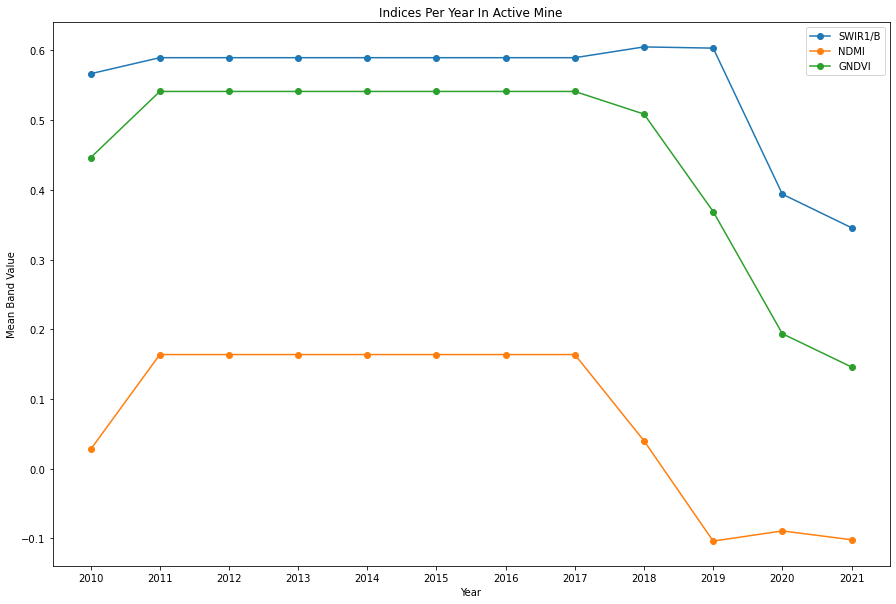

In [7]:
images = ee.ImageCollection(create_layers(2010, 2021, active))
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_layers(2010, 2021, active)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)

xticks = [t[4] for t in images]
ax.set_xticks([i for i in range(12)], xticks)

df.plot(ax=ax,
       title = 'Indices Per Year In Active Mine',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

#plt.ylim([-0.25, 0.25])
plt.show()

In [43]:
images = ee.ImageCollection(create_layers(2008, 2021, active))
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)

gndvi = df["GNDVI"]
swirb = df["SWIR1/B"]
ndmi = df["NDMI"]
x_vals = df["Year"].astype(int) + 2008 # years 2008-2021

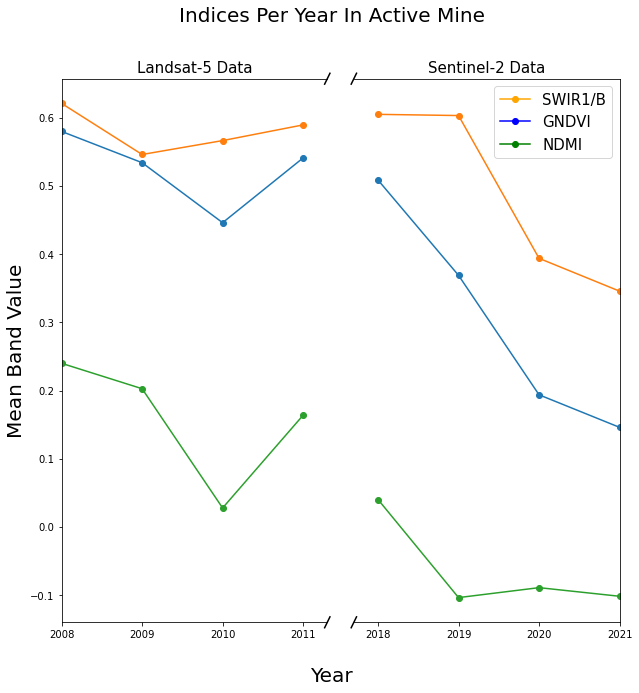

In [49]:
# f, (ax, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 4]})
f, (ax, ax2) = plt.subplots(1, 2, figsize=(10,10), sharey=True)

# plot the same data on both axes
ax.plot(x_vals[0:4], gndvi[0:4], marker='o')
ax.plot(x_vals[0:4], swirb[0:4], marker='o')
ax.plot(x_vals[0:4], ndmi[0:4], marker='o')

ax2.plot(x_vals[10:14], gndvi[10:14], marker='o')
ax2.plot(x_vals[10:14], swirb[10:14], marker='o')
ax2.plot(x_vals[10:14], ndmi[10:14], marker='o')

# zoom-in / limit the view to different portions of the data
ax.set_xlim(2008, 2011.3)  # LS5
ax2.set_xlim(2017.7, 2021)  # S2

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    labelleft=False) # labels along the left edge are off

ax.set_xticks([2008, 2009, 2010, 2011])
ax2.set_xticks([2018, 2019, 2020, 2021])

ax.set_title('Landsat-5 Data', fontsize = 15)
ax2.set_title('Sentinel-2 Data', fontsize = 15)
plt.suptitle('Indices Per Year In Active Mine', fontsize = 20)
ax.set_ylabel('Mean Band Value', fontsize = 20)
f.text(0.5, 0.05, 'Year', ha='center', va='center', fontsize = 20)

# Diagonal Lines
d = .01  # size of the diagonal lines
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-right diagonal

plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend
orange_line = mlines.Line2D([], [], color='orange', label='SWIR1/B', marker='o')
blue_line = mlines.Line2D([], [], color='blue', label='GNDVI', marker='o')
green_line = mlines.Line2D([], [], color='green', label='NDMI', marker='o')
plt.legend(handles=[orange_line, blue_line, green_line], prop={'size': 15})

plt.show()

In [66]:
print(gndvi)

0     0.579977
1     0.534122
2     0.446118
3     0.541134
4     0.541134
5     0.541134
6     0.541134
7     0.541134
8     0.541134
9     0.541134
10    0.508681
11    0.368912
12    0.193708
13    0.145966
Name: GNDVI, dtype: float64


In [76]:
gndvi_adj = gndvi.drop(
    labels=[4,5,6,7,8,9],
    axis=0,
    inplace=False)
swirb_adj = swirb.drop(
    labels=[4,5,6,7,8,9],
    axis=0,
    inplace=False)
ndmi_adj = ndmi.drop(
    labels=[4,5,6,7,8,9],
    axis=0,
    inplace=False)
x_adj = x_vals.drop(
    labels=[4,5,6,7,8,9],
    axis=0,
    inplace=False)

In [72]:
print(x_adj)

0     2008
1     2009
2     2010
3     2011
10    2018
11    2019
12    2020
13    2021
Name: Year, dtype: int64


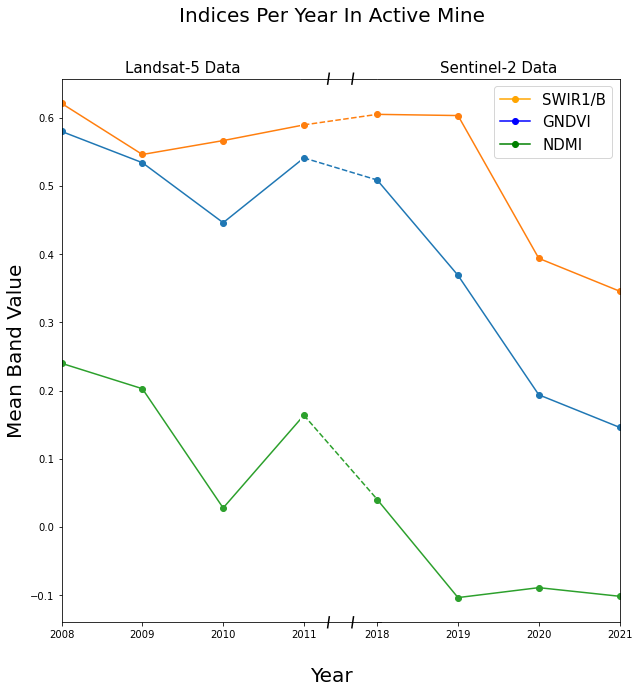

In [96]:
# f, (ax, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 4]})
f, (ax, axMid, ax2) = plt.subplots(1, 3, figsize=(10,10), sharey=True, gridspec_kw={'width_ratios': [3, 1, 3]})
# plot the same data on both axes
# linestyle='dashed'
ax.plot(x_vals[0:4], gndvi[0:4], marker='o')
ax.plot(x_vals[0:4], swirb[0:4], marker='o')
ax.plot(x_vals[0:4], ndmi[0:4], marker='o')
axMid.plot(x_adj[3:5], gndvi_adj[3:5], linestyle='dashed', marker='o')
axMid.plot(x_adj[3:5], swirb_adj[3:5], linestyle='dashed', marker='o')
axMid.plot(x_adj[3:5], ndmi_adj[3:5], linestyle='dashed', marker='o')
ax2.plot(x_vals[10:14], gndvi[10:14], marker='o')
ax2.plot(x_vals[10:14], swirb[10:14], marker='o')
ax2.plot(x_vals[10:14], ndmi[10:14], marker='o')

# zoom-in / limit the view to different portions of the data
ax.set_xlim(2008, 2011)  # LS5
ax2.set_xlim(2018, 2021)  # S2

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
axMid.spines['left'].set_visible(False)
axMid.spines['right'].set_visible(False)

ax2.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    labelleft=False) # labels along the left edge are off

axMid.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    labelleft=False) # labels along the left edge are off

axMid.tick_params(
    axis='x',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the left edge are off
    labelbottom=False) # labels along the left edge are off

ax.set_xticks([2008, 2009, 2010, 2011])
ax2.set_xticks([2018, 2019, 2020, 2021])

ax.set_title('Landsat-5 Data', fontsize = 15)
ax2.set_title('Sentinel-2 Data', fontsize = 15)
plt.suptitle('Indices Per Year In Active Mine', fontsize = 20)
ax.set_ylabel('Mean Band Value', fontsize = 20)
f.text(0.5, 0.05, 'Year', ha='center', va='center', fontsize = 20)

# Diagonal Lines
d = .01  # size of the diagonal lines
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((1-d, 1+d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)  # top-right diagonal
# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-right diagonal

kwargs = dict(transform=axMid.transAxes, color='k', clip_on=False)
axMid.plot((.65-d, .65+d), (-d, +d), **kwargs)        # bottom-right diagonal
axMid.plot((.65 - d, .65 + d), (1-d, 1+d), **kwargs)  # top-right diagonal
axMid.plot((.35-d, .35+d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
axMid.plot((.35-d, .35+d), (-d, +d), **kwargs)  # bottom-left diagonal

plt.subplots_adjust(wspace=-0.02, hspace=0)

# Legend
orange_line = mlines.Line2D([], [], color='orange', label='SWIR1/B', marker='o')
blue_line = mlines.Line2D([], [], color='blue', label='GNDVI', marker='o')
green_line = mlines.Line2D([], [], color='green', label='NDMI', marker='o')
plt.legend(handles=[orange_line, blue_line, green_line], prop={'size': 15})

plt.show()